In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/bin/imports.ipynb")
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/alternate/sample_mapping.ipynb")

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('/cellar/users/ramarty/Data/kir/TCGA/data_frames/all_the_good_stuff.csv', index_col=0)

In [6]:
cell_types = [u'B cells naive',
       u'B cells memory', u'Plasma cells', u'T cells CD8',
       u'T cells CD4 naive', u'T cells CD4 memory resting',
       u'T cells CD4 memory activated', u'T cells follicular helper',
       u'T cells regulatory (Tregs)', u'T cells gamma delta',
       u'NK cells resting', u'NK cells activated', u'Monocytes',
       u'Macrophages M0', u'Macrophages M1', u'Macrophages M2',
       u'Dendritic cells resting', u'Dendritic cells activated',
       u'Mast cells resting', u'Mast cells activated', u'Eosinophils',
       u'Neutrophils']

In [7]:
genes = ['KIR3DL3', 'KIR3DP1', 'KIR2DL4', 'KIR3DL2', 'KIR2DS2', 'KIR2DS3', 'KIR2DP1', 
         'KIR2DL1', 'KIR3DS1', 'KIR2DS5', 'KIR2DS4']

In [8]:
df.columns

Index([u'KIR3DL3', u'KIR3DP1', u'KIR2DL4', u'KIR3DL2', u'KIR2DP1', u'KIR2DL1',
       u'KIR2DS4', u'KIR2DL5', u'KIR2DS3', u'KIR2DS2', u'KIR2DS5', u'KIR3DS1',
       u'KIR2DS1', u'KIR2DL2', u'KIR3DL1', u'KIR2DL3', u'age_at_diagnosis',
       u'days_to_death', u'days_to_last_followup', u'ethnicity', u'gender',
       u'race', u'tissue', u'vital_status', u'B cells naive',
       u'B cells memory', u'Plasma cells', u'T cells CD8',
       u'T cells CD4 naive', u'T cells CD4 memory resting',
       u'T cells CD4 memory activated', u'T cells follicular helper',
       u'T cells regulatory (Tregs)', u'T cells gamma delta',
       u'NK cells resting', u'NK cells activated', u'Monocytes',
       u'Macrophages M0', u'Macrophages M1', u'Macrophages M2',
       u'Dendritic cells resting', u'Dendritic cells activated',
       u'Mast cells resting', u'Mast cells activated', u'Eosinophils',
       u'Neutrophils', u'P-value', u'Pearson Correlation', u'RMSE', u'A1',
       u'A2', u'B1', u'B2', u'C1', u'

MHC/KIR/Neo -> Infiltration (stratified by tissue)

In [9]:
hla_a = [x.split(',')[1:3] for x in open('/cellar/users/ramarty/Data/kir/biological/combinations.hla_a.csv').readlines()[1:]]
hla_b = [x.split(',')[1:3] for x in open('/cellar/users/ramarty/Data/kir/biological/combinations.hla_b.csv').readlines()[1:]]
hla_c = [x.split(',')[1:3] for x in open('/cellar/users/ramarty/Data/kir/biological/combinations.hla_c.csv').readlines()[1:]]

In [10]:
predicted_total = 138
total = 0
for gene in genes:
    for hla1, hla2 in hla_a:
        for cell in ['NKcells', 'Tcells']:
            h = (df.A1 == hla1)&(df.A2 == hla2)
            k = df[gene] > 1
            n = df['num_neoantigens10'] > df['num_neoantigens10'].quantile()
            if len(df[k&h][cell]) > 5 and len(df[~k&h][cell]) > 5:
                total += 1
                test1 = sp.ttest_ind(df[k&n&h][cell], df[(k&~n&h)|(~k&n&h)|(~k&~n&h)][cell])[1]
                test2 = sp.ttest_ind(df[k&~n&h][cell], df[(k&n&h)|(~k&n&h)|(~k&~n&h)][cell])[1]
                test3 = sp.ttest_ind(df[~k&n&h][cell], df[(k&n&h)|(k&~n&h)|(~k&~n&h)][cell])[1]
                test4 = sp.ttest_ind(df[~k&~n&h][cell], df[(k&n&h)|(k&~n&h)|(~k&n&h)][cell])[1]
                # test one against all others
                if test1 * predicted_total < 0.05 or test2 * predicted_total < 0.05 or \
                    test3 * predicted_total < 0.05 or test4 * predicted_total < 0.05:
                    try:
                        min_p = min(test1, test2, test3, test4) * predicted_total
                        print cell, gene, hla1, hla2, len(df[k&n&h]), len(df[k&~n&h]), len(df[~k&n&h]), len(df[~k&~n&h])
                        f, ax = plt.subplots()
                        violin_parts = ax.violinplot([df[k&n&h][cell], df[k&~n&h][cell], df[~k&n&h][cell], df[~k&~n&h][cell]])
                        for pc in violin_parts['bodies']:
                            pc.set_facecolor('grey')
                            pc.set_edgecolor('black')
                        plt.ylabel('Infiltration of {0}'.format(cell))
                        ax.set_xticklabels(['', 'High K-High Neo - {0}'.format(len(df[k&n&h])), '', 'High K-Low Neo - {0}'.format(len(df[k&~n&h])),
                                                                               ' ', 'Low K-High Neo - {0}'.format(len(df[~k&n&h])), ' ', 'Low K-Low Neo - {0}'.format(len(df[~k&~n&h]))])
                        plt.xticks(rotation=45)
                        plt.title('{0},{1},{2} - {3}'.format(hla1, hla2, gene, str(min_p)))
                        #plt.savefig('/cellar/users/ramarty/Data/kir/figures/infiltration.hla.{0}.{1}.{2}.pdf'.format(cell, hla1, hla2))
                        plt.show()
                        plt.clf()
                    except:
                        None
print total

KeyError: 'num_neoantigens10'

In [55]:
predicted_total = 78
total = 0
for gene in genes:
    for hla1, hla2 in hla_b:
        for cell in ['NKcells', 'Tcells']:
            h = (df.B1 == hla1)&(df.B2 == hla2)
            k = df[gene] > 1
            n = df['num_neoantigens10'] > df['num_neoantigens10'].quantile()
            if len(df[k&h][cell]) > 5 and len(df[~k&h][cell]) > 5:
                total += 1
                test1 = sp.ttest_ind(df[k&n&h][cell], df[(k&~n&h)|(~k&n&h)|(~k&~n&h)][cell])[1]
                test2 = sp.ttest_ind(df[k&~n&h][cell], df[(k&n&h)|(~k&n&h)|(~k&~n&h)][cell])[1]
                test3 = sp.ttest_ind(df[~k&n&h][cell], df[(k&n&h)|(k&~n&h)|(~k&~n&h)][cell])[1]
                test4 = sp.ttest_ind(df[~k&~n&h][cell], df[(k&n&h)|(k&~n&h)|(~k&n&h)][cell])[1]
                # test one against all others
                if test1 * predicted_total < 0.05 or test2 * predicted_total < 0.05 or \
                    test3 * predicted_total < 0.05 or test4 * predicted_total < 0.05:
                    try:
                        min_p = min(test1, test2, test3, test4) * predicted_total
                        print cell, gene, hla1, hla2, len(df[k&n&h]), len(df[k&~n&h]), len(df[~k&n&h]), len(df[~k&~n&h])
                        f, ax = plt.subplots()
                        ax.violinplot([df[k&n&h][cell], df[k&~n&h][cell], df[~k&n&h][cell], df[~k&~n&h][cell]])
                        #plt.ylim(0, 0.3)
                        plt.ylabel('Infiltration of {0}'.format(cell))
                        ax.set_xticklabels(['', 'High K-High Neo', '', 'High K-Low Neo', ' ', 'Low K-High Neo', ' ', 'Low K-Low Neo'])
                        plt.title('{0},{1},{2} - {3}'.format(hla1, hla2, gene, str(min_p)))
                        plt.show()
                        plt.clf()
                    except:
                        None
print total

80


Tcells KIR2DP1 C*07 C*08 13 7 2 4


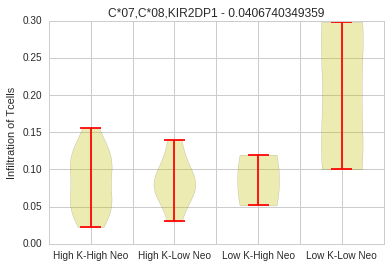

NKcells KIR2DS4 C*01 C*07 4 4 3 4


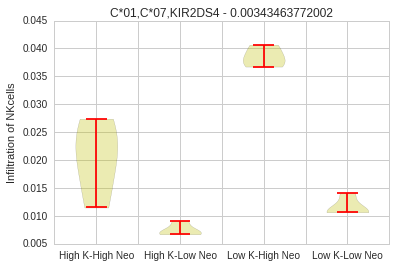

138


In [56]:
predicted_total = 134
total = 0
for gene in genes:
    for hla1, hla2 in hla_c:
        for cell in ['NKcells', 'Tcells']:
            h = (df.C1 == hla1)&(df.C2 == hla2)
            k = df[gene] > 1
            n = df['num_neoantigens10'] > df['num_neoantigens10'].quantile()
            if len(df[k&h][cell]) > 5 and len(df[~k&h][cell]) > 5:
                total += 1
                test1 = sp.ttest_ind(df[k&n&h][cell], df[(k&~n&h)|(~k&n&h)|(~k&~n&h)][cell])[1]
                test2 = sp.ttest_ind(df[k&~n&h][cell], df[(k&n&h)|(~k&n&h)|(~k&~n&h)][cell])[1]
                test3 = sp.ttest_ind(df[~k&n&h][cell], df[(k&n&h)|(k&~n&h)|(~k&~n&h)][cell])[1]
                test4 = sp.ttest_ind(df[~k&~n&h][cell], df[(k&n&h)|(k&~n&h)|(~k&n&h)][cell])[1]
                # test one against all others
                if test1 * predicted_total < 0.05 or test2 * predicted_total < 0.05 or \
                    test3 * predicted_total < 0.05 or test4 * predicted_total < 0.05:
                    try:
                        min_p = min(test1, test2, test3, test4) * predicted_total
                        print cell, gene, hla1, hla2, len(df[k&n&h]), len(df[k&~n&h]), len(df[~k&n&h]), len(df[~k&~n&h])
                        f, ax = plt.subplots()
                        ax.violinplot([df[k&n&h][cell], df[k&~n&h][cell], df[~k&n&h][cell], df[~k&~n&h][cell]])
                        #plt.ylim(0, 0.3)
                        plt.ylabel('Infiltration of {0}'.format(cell))
                        ax.set_xticklabels(['', 'High K-High Neo', '', 'High K-Low Neo', ' ', 'Low K-High Neo', ' ', 'Low K-Low Neo'])
                        plt.title('{0},{1},{2} - {3}'.format(hla1, hla2, gene, str(min_p)))
                        plt.show()
                        plt.clf()
                    except:
                        None
print total

Known MHC/KIR interactors -> infiltration (stratified by tissue)

In [7]:
bw4 = ['B*05', 'B*13', 'B*17', 'B*27', 'B*37', 'B*38', 'B*44', 'B*47', 'B*49', 'B*51', 
       'B*52', 'B*53', 'B*57', 'B*58', 'B*59', 'B*63', 'B*77', 'A*09', 'A*23', 'A*24',
       'A*24', 'A*25', 'A*32']

In [8]:
def categorize_bw4(x):
    return in_bw4(x[0]) + in_bw4(x[1]) + in_bw4(x[2]) + in_bw4(x[3])
def in_bw4(x):
    if x in bw4:
        return 1
    else:
        return 0 
df['bw4'] = df[['A1', 'A2', 'B1', 'B2']].apply(categorize_bw4, axis=1)

In [9]:
activating_combo1 = (df.KIR3DS1 > 0) & (df.bw4 > 0)
activating_combo2 = (df.KIR2DS1 > 0) & ((df.C1 == 'C*02')&(df.C2 == 'C*02')|(df.C1 == 'C*01')&(df.C2 == 'C*02')|(df.C1 == 'C*02')&(df.C2 == 'C*01'))
activating_combo3 = (df.KIR2DS2 > 0) & ((df.C1 == 'C*01')&(df.C2 == 'C*01')|(df.C1 == 'C*01')&(df.C2 == 'C*02')|(df.C1 == 'C*02')&(df.C2 == 'C*01'))

In [10]:
inactivating_combo1 = (df.KIR3DL1 > 0) & (df.bw4 > 0)
inactivating_combo2 = (df.KIR2DL1 > 0) & ((df.C1 == 'C*02')&(df.C2 == 'C*02')|(df.C1 == 'C*01')&(df.C2 == 'C*02')|(df.C1 == 'C*02')&(df.C2 == 'C*01'))
inactivating_combo3 = (df.KIR2DL2 > 0) & ((df.C1 == 'C*01')&(df.C2 == 'C*01')|(df.C1 == 'C*01')&(df.C2 == 'C*02')|(df.C1 == 'C*02')&(df.C2 == 'C*01'))
inactivating_combo4 = (df.KIR2DL3 > 0) & ((df.C1 == 'C*01')&(df.C2 == 'C*01')|(df.C1 == 'C*01')&(df.C2 == 'C*02')|(df.C1 == 'C*02')&(df.C2 == 'C*01'))

316 975
NKcells 316 975


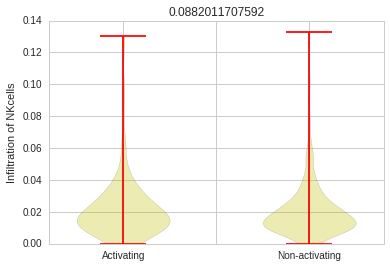

316 975
Tcells 316 975


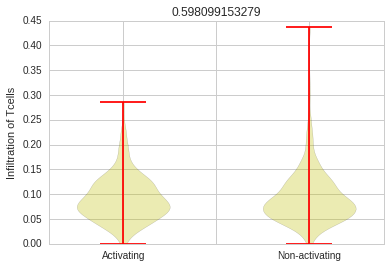

0 1291
0 1291
3 1288
3 1288
2


In [61]:
# test for infiltration differences between activating and inactivating; separately and together
predicted_total = 1
total = 0
for activating_combo in [activating_combo1, activating_combo2, activating_combo3]:
    for cell in ['NKcells', 'Tcells']:
        print len(df[activating_combo]), len(df[~activating_combo])
        if len(df[activating_combo][cell]) > 5 and len(df[~activating_combo][cell]) > 5:
            total += 1
            test = sp.ttest_ind(df[activating_combo][cell], df[~activating_combo][cell])[1]
            # test one against all others
            #if test * predicted_total < 0.05:
            print cell, len(df[activating_combo]), len(df[~activating_combo])
            f, ax = plt.subplots()
            ax.violinplot([df[activating_combo][cell], df[~activating_combo][cell]])
            #plt.ylim(0, 0.3)
            plt.ylabel('Infiltration of {0}'.format(cell))
            ax.set_xticklabels(['', 'Activating', '', 'Non-activating'])
            plt.title('{0}'.format(str(test)))
            plt.show()
            plt.clf()
print total

876 415
NKcells 876 415
0.0176147645272 0.0150649687348


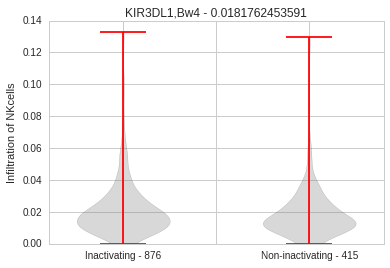

876 415
5 1286
5 1286
3 1288
3 1288
7 1284
7 1284
2


In [80]:
# test for infiltration differences between activating and inactivating; separately and together
predicted_total = 2
total = 0
for inactivating_combo in [inactivating_combo1, inactivating_combo2, inactivating_combo3, inactivating_combo4]:
    for cell in ['NKcells', 'Tcells']:
        print len(df[inactivating_combo]), len(df[~inactivating_combo])
        if len(df[inactivating_combo][cell]) > 10 and len(df[~inactivating_combo][cell]) > 10:
            total += 1
            test = sp.ttest_ind(df[inactivating_combo][cell], df[~inactivating_combo][cell])[1]
            # test one against all others
            if test * predicted_total < 0.05:
                print cell, len(df[inactivating_combo]), len(df[~inactivating_combo])
                print df[inactivating_combo][cell].median(), df[~inactivating_combo][cell].median()
                f, ax = plt.subplots()
                violin_parts = ax.violinplot([df[inactivating_combo][cell], df[~inactivating_combo][cell]])
                for pc in violin_parts['bodies']:
                    pc.set_facecolor('grey')
                    pc.set_edgecolor('black')
                #ax.boxplot([df[inactivating_combo][cell], df[~inactivating_combo][cell]])
                #plt.ylim(0, 0.05)
                plt.ylabel('Infiltration of {0}'.format(cell))
                ax.set_xticklabels([' ', 'Inactivating - {0}'.format(len(df[inactivating_combo])), ' ', 'Non-inactivating - {0}'.format(len(df[~inactivating_combo]))])
                plt.title('KIR3DL1,Bw4 - {0}'.format(str(test * predicted_total)))
                plt.savefig('/cellar/users/ramarty/Data/kir/figures/infiltration.hla.{0}.{1}.{2}.pdf'.format(cell, 'KIR3DL1', 'Bw4'))
                plt.show()
                plt.clf()
print total

HNSC Tcells 244 123
0.105998601277 0.0876283441028


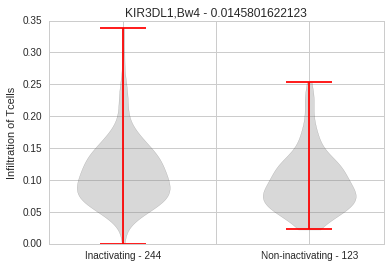

12


In [12]:
# tissue specific
predicted_total = 2
total = 0
for tissue in df.tissue.unique():
    t = df.tissue == tissue
    for inactivating_combo in [inactivating_combo1, inactivating_combo2, inactivating_combo3, inactivating_combo4]:
        for cell in ['NKcells', 'Tcells']:
            #print len(df[t&inactivating_combo]), len(df[t&~inactivating_combo])
            if len(df[t&inactivating_combo][cell]) > 10 and len(df[t&~inactivating_combo][cell]) > 10:
                total += 1
                test = sp.ttest_ind(df[t&inactivating_combo][cell], df[t&~inactivating_combo][cell])[1]
                # test one against all others
                if test * predicted_total < 0.05:
                    print tissue, cell, len(df[t&inactivating_combo]), len(df[t&~inactivating_combo])
                    print df[t&inactivating_combo][cell].median(), df[t&~inactivating_combo][cell].median()
                    f, ax = plt.subplots()
                    violin_parts = ax.violinplot([df[t&inactivating_combo][cell], df[t&~inactivating_combo][cell]])
                    for pc in violin_parts['bodies']:
                        pc.set_facecolor('grey')
                        pc.set_edgecolor('black')
                    #ax.boxplot([df[inactivating_combo][cell], df[~inactivating_combo][cell]])
                    #plt.ylim(0, 0.05)
                    plt.ylabel('Infiltration of {0}'.format(cell))
                    ax.set_xticklabels([' ', 'Inactivating - {0}'.format(len(df[t&inactivating_combo])), ' ', 'Non-inactivating - {0}'.format(len(df[t&~inactivating_combo]))])
                    plt.title('KIR3DL1,Bw4 - {0}'.format(str(test * predicted_total)))
                    #plt.savefig('/cellar/users/ramarty/Data/kir/figures/infiltration.hla.{0}.{1}.{2}.pdf'.format(cell, 'KIR3DL1', 'Bw4'))
                    plt.show()
                    plt.clf()
print total

What does inactivating and activating mean?

With specific HLA/KIR backgrounds, does neoantigen count impact immune infiltration?

NKcells KIR3DL3 A*01 A*68 7 15


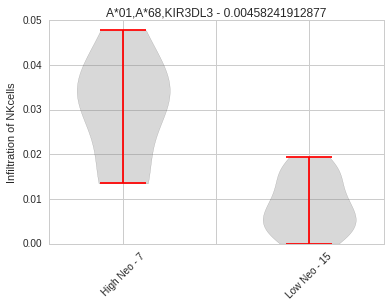

NKcells KIR3DP1 A*01 A*68 7 15


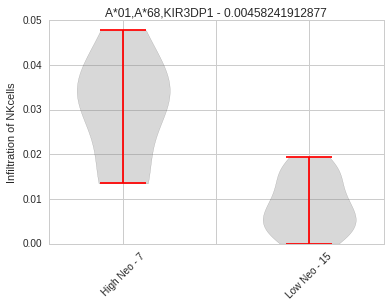

NKcells KIR2DL4 A*01 A*68 7 15


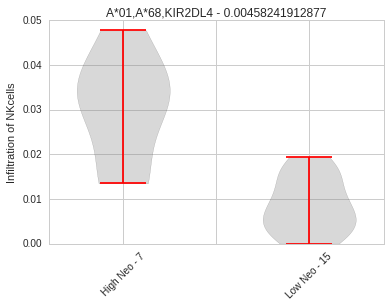

NKcells KIR3DL2 A*01 A*68 7 15


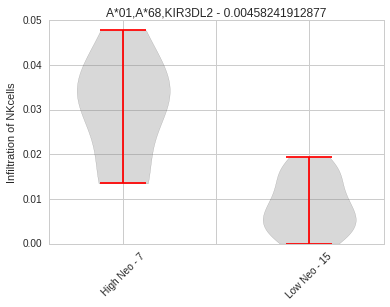

NKcells KIR2DP1 A*01 A*68 7 15


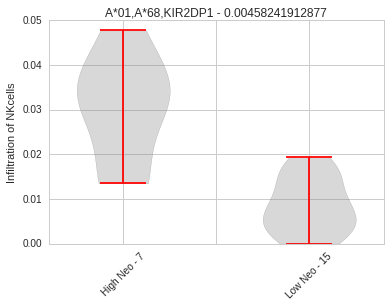

NKcells KIR2DL1 A*01 A*68 7 15


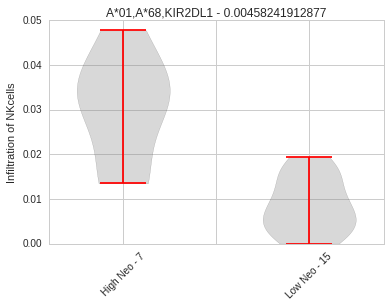

NKcells KIR2DS4 A*01 A*68 7 15


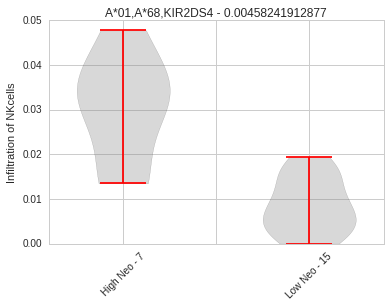

326


In [63]:
predicted_total = 226
total = 0
for gene in genes:
    for hla1, hla2 in hla_a:
        for cell in ['NKcells', 'Tcells']:
            h = (df.A1 == hla1)&(df.A2 == hla2)
            k = df[gene] > 0
            n = df['num_neoantigens10'] > df['num_neoantigens10'].quantile()
            if len(df[k&h&~n][cell]) > 5 and len(df[k&h&n][cell]) > 5:
                total += 1
                test1 = sp.ttest_ind(df[k&h&n][cell], df[k&h&~n][cell])[1]

                # test one against all others
                if test1 * predicted_total < 0.05:
                    try:
                        min_p = min(test1, test2, test3, test4) * predicted_total
                        print cell, gene, hla1, hla2, len(df[k&h&n]), len(df[k&h&~n])
                        f, ax = plt.subplots()
                        violin_parts = ax.violinplot([df[k&h&n][cell], df[k&h&~n][cell]])
                        for pc in violin_parts['bodies']:
                            pc.set_facecolor('grey')
                            pc.set_edgecolor('black')
                        plt.ylabel('Infiltration of {0}'.format(cell))
                        ax.set_xticklabels(['', 'High Neo - {0}'.format(len(df[k&n&h])), '', 'Low Neo - {0}'.format(len(df[k&~n&h]))])
                        plt.xticks(rotation=45)
                        plt.title('{0},{1},{2} - {3}'.format(hla1, hla2, gene, str(min_p)))
                        #plt.savefig('/cellar/users/ramarty/Data/kir/figures/infiltration.hla.{0}.{1}.{2}.pdf'.format(cell, hla1, hla2))
                        plt.show()
                        plt.clf()
                    except:
                        None
print total

In [70]:
predicted_total = 180
total = 0
for gene in genes:
    for hla1, hla2 in hla_b:
        for cell in ['NKcells', 'Tcells']:
            h = (df.B1 == hla1)&(df.B2 == hla2)
            k = df[gene] > 1
            n = df['num_neoantigens10'] > df['num_neoantigens10'].quantile()
            if len(df[k&h&~n][cell]) > 5 and len(df[k&h&n][cell]) > 5:
                total += 1
                test1 = sp.ttest_ind(df[k&h&n][cell], df[k&h&~n][cell])[1]

                # test one against all others
                if test1 * predicted_total < 0.05:
                    try:
                        min_p = min(test1, test2, test3, test4) * predicted_total
                        print cell, gene, hla1, hla2, len(df[k&h&n]), len(df[k&h&~n])
                        f, ax = plt.subplots()
                        violin_parts = ax.violinplot([df[k&h&n][cell], df[k&h&~n][cell]])
                        for pc in violin_parts['bodies']:
                            pc.set_facecolor('grey')
                            pc.set_edgecolor('black')
                        plt.ylabel('Infiltration of {0}'.format(cell))
                        ax.set_xticklabels(['', 'High Neo - {0}'.format(len(df[k&n&h])), '', 'Low Neo - {0}'.format(len(df[k&~n&h]))])
                        plt.xticks(rotation=45)
                        plt.title('{0},{1},{2} - {3}'.format(hla1, hla2, gene, str(min_p)))
                        #plt.savefig('/cellar/users/ramarty/Data/kir/figures/infiltration.hla.{0}.{1}.{2}.pdf'.format(cell, hla1, hla2))
                        plt.show()
                        plt.clf()
                    except:
                        None
print total

180


In [72]:
predicted_total = 242
total = 0
for gene in genes:
    for hla1, hla2 in hla_c:
        for cell in ['NKcells', 'Tcells']:
            h = (df.C1 == hla1)&(df.C2 == hla2)
            k = df[gene] > 1
            n = df['num_neoantigens10'] > df['num_neoantigens10'].quantile()
            if len(df[k&h&~n][cell]) > 5 and len(df[k&h&n][cell]) > 5:
                total += 1
                test1 = sp.ttest_ind(df[k&h&n][cell], df[k&h&~n][cell])[1]

                # test one against all others
                if test1 * predicted_total < 0.05:
                    try:
                        min_p = min(test1, test2, test3, test4) * predicted_total
                        print cell, gene, hla1, hla2, len(df[k&h&n]), len(df[k&h&~n])
                        f, ax = plt.subplots()
                        violin_parts = ax.violinplot([df[k&h&n][cell], df[k&h&~n][cell]])
                        for pc in violin_parts['bodies']:
                            pc.set_facecolor('grey')
                            pc.set_edgecolor('black')
                        plt.ylabel('Infiltration of {0}'.format(cell))
                        ax.set_xticklabels(['', 'High Neo - {0}'.format(len(df[k&n&h])), '', 'Low Neo - {0}'.format(len(df[k&~n&h]))])
                        plt.xticks(rotation=45)
                        plt.title('{0},{1},{2} - {3}'.format(hla1, hla2, gene, str(min_p)))
                        #plt.savefig('/cellar/users/ramarty/Data/kir/figures/infiltration.hla.{0}.{1}.{2}.pdf'.format(cell, hla1, hla2))
                        plt.show()
                        plt.clf()
                    except:
                        None
print total

242


Looking only at HLA type

NKcells A*01 A*68 7 15


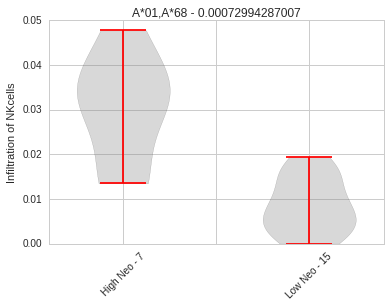

38


In [76]:
# only HLA type important
predicted_total = 36
total = 0
for hla1, hla2 in hla_a:
    for cell in ['NKcells', 'Tcells']:
        h = (df.A1 == hla1)&(df.A2 == hla2)
        n = df['num_neoantigens10'] > df['num_neoantigens10'].quantile()
        if len(df[h&~n][cell]) > 5 and len(df[h&n][cell]) > 5:
            total += 1
            test1 = sp.ttest_ind(df[h&n][cell], df[h&~n][cell])[1]

            # test one against all others
            if test1 * predicted_total < 0.05:
                try:
                    min_p = test1 * predicted_total
                    print cell, hla1, hla2, len(df[h&n]), len(df[h&~n])
                    f, ax = plt.subplots()
                    violin_parts = ax.violinplot([df[h&n][cell], df[h&~n][cell]])
                    for pc in violin_parts['bodies']:
                        pc.set_facecolor('grey')
                        pc.set_edgecolor('black')
                    plt.ylabel('Infiltration of {0}'.format(cell))
                    ax.set_xticklabels(['', 'High Neo - {0}'.format(len(df[n&h])), '', 'Low Neo - {0}'.format(len(df[~n&h]))])
                    plt.xticks(rotation=45)
                    plt.title('{0},{1} - {2}'.format(hla1, hla2, str(min_p)))
                    plt.savefig('/cellar/users/ramarty/Data/kir/figures/infiltration.hla_neo.{0}.{1}.{2}.pdf'.format(cell, hla1, hla2))
                    plt.show()
                    plt.clf()
                except:
                    None
print total

In [67]:
# only HLA type important
predicted_total = 30
total = 0
for hla1, hla2 in hla_b:
    for cell in ['NKcells', 'Tcells']:
        h = (df.B1 == hla1)&(df.B2 == hla2)
        n = df['num_neoantigens10'] > df['num_neoantigens10'].quantile()
        if len(df[h&~n][cell]) > 5 and len(df[h&n][cell]) > 5:
            total += 1
            test1 = sp.ttest_ind(df[h&n][cell], df[h&~n][cell])[1]

            # test one against all others
            if test1 * predicted_total < 0.05:
                try:
                    min_p = min(test1, test2, test3, test4) * predicted_total
                    print cell, hla1, hla2, len(df[h&n]), len(df[h&~n])
                    f, ax = plt.subplots()
                    violin_parts = ax.violinplot([df[h&n][cell], df[h&~n][cell]])
                    for pc in violin_parts['bodies']:
                        pc.set_facecolor('grey')
                        pc.set_edgecolor('black')
                    plt.ylabel('Infiltration of {0}'.format(cell))
                    ax.set_xticklabels(['', 'High Neo - {0}'.format(len(df[n&h])), '', 'Low Neo - {0}'.format(len(df[~n&h]))])
                    plt.xticks(rotation=45)
                    plt.title('{0},{1},{2} - {3}'.format(hla1, hla2, gene, str(min_p)))
                    #plt.savefig('/cellar/users/ramarty/Data/kir/figures/infiltration.hla.{0}.{1}.{2}.pdf'.format(cell, hla1, hla2))
                    plt.show()
                    plt.clf()
                except:
                    None
print total

30


NKcells C*01 C*07 7 8


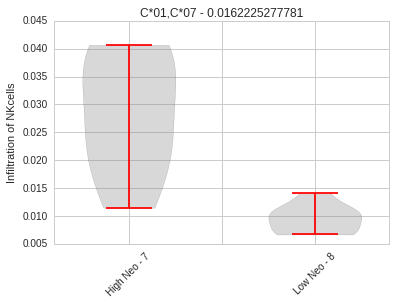

38


In [77]:
# only HLA type important
predicted_total = 38
total = 0
for hla1, hla2 in hla_c:
    for cell in ['NKcells', 'Tcells']:
        h = (df.C1 == hla1)&(df.C2 == hla2)
        n = df['num_neoantigens10'] > df['num_neoantigens10'].quantile()
        if len(df[h&~n][cell]) > 5 and len(df[h&n][cell]) > 5:
            total += 1
            test1 = sp.ttest_ind(df[h&n][cell], df[h&~n][cell])[1]

            # test one against all others
            if test1 * predicted_total < 0.05:
                try:
                    min_p = test1 * predicted_total
                    print cell, hla1, hla2, len(df[h&n]), len(df[h&~n])
                    f, ax = plt.subplots()
                    violin_parts = ax.violinplot([df[h&n][cell], df[h&~n][cell]])
                    for pc in violin_parts['bodies']:
                        pc.set_facecolor('grey')
                        pc.set_edgecolor('black')
                    plt.ylabel('Infiltration of {0}'.format(cell))
                    ax.set_xticklabels(['', 'High Neo - {0}'.format(len(df[n&h])), '', 'Low Neo - {0}'.format(len(df[~n&h]))])
                    plt.xticks(rotation=45)
                    plt.title('{0},{1} - {2}'.format(hla1, hla2, str(min_p)))
                    plt.savefig('/cellar/users/ramarty/Data/kir/figures/infiltration.hla_neo.{0}.{1}.{2}.pdf'.format(cell, hla1, hla2))
                    plt.show()
                    plt.clf()
                except:
                    None
print total